# Ex 1

1. Generaţi 500 de date dintr-o mixtură de trei distribuţii Gaussiene. În fişierul alăturat aveţi un astfel de exemplu.

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


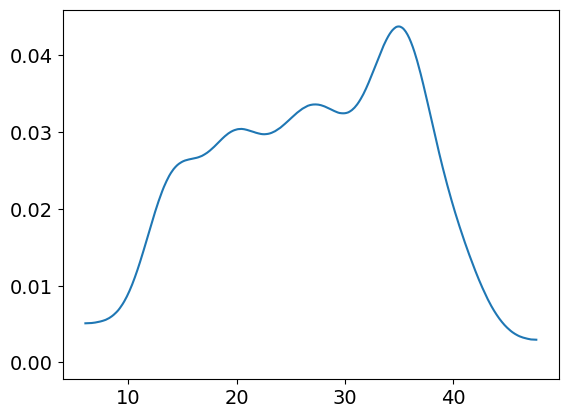

In [1]:
import statistics as stats
import numpy as np
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats

n_cluster = [166, 167, 167]
n_total = sum(n_cluster)
means = np.random.randint(0, 50, 3)
std_devs = np.random.randint(0, 10, 3)
mix = np.random.normal(np.repeat(means, n_cluster),np.repeat(std_devs, n_cluster))
az.plot_kde(np.array(mix))
plt.show()

2. Calibraţi pe acest set de date un model de mixtură de distribuţii Gaussiene cu 2, 3, respectiv 4 componente.

In [2]:
models = []
idatas = []
clusters = [2, 3, 4]

for cluster in clusters:
    with pm.Model() as model:
        w = pm.Dirichlet('w', a=np.ones(cluster))
        means = pm.Normal('means',
                          mu=np.linspace(mix.min(), mix.max(), cluster),
                          sigma=10, shape=cluster)
        sd = pm.HalfNormal('sd', sigma=10)
        y = pm.NormalMixture('y', w=w, mu=means, sigma=sd, observed=mix)
        idata = pm.sample(1000, tune=2000, target_accept = 0.9, random_seed = 7, return_inferencedata=True)
        idatas.append(idata)
        models.append(model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, means, sd]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, means, sd]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 56 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, means, sd]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


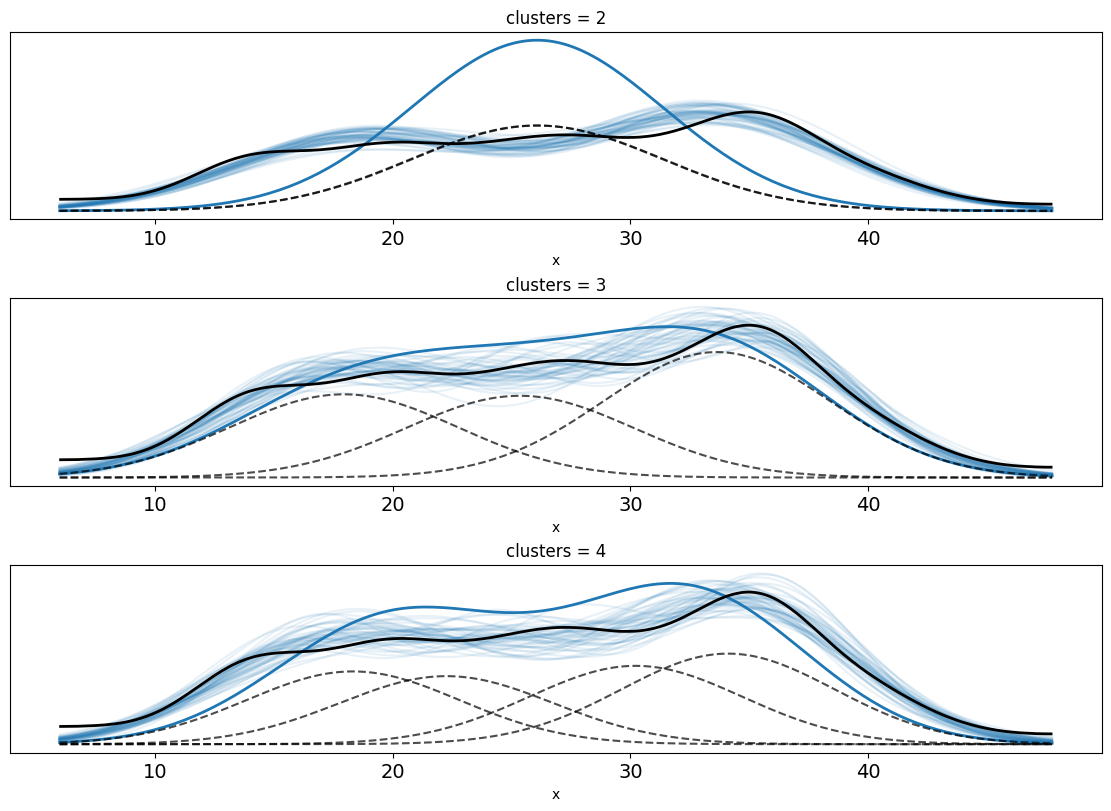

In [3]:
_, ax = plt.subplots(3, figsize=(11, 8), constrained_layout=True)
ax = np.ravel(ax)
x = np.linspace(mix.min(), mix.max(), 200)

for idx, idata_x in enumerate(idatas):
    posterior_x = idata_x.posterior.stack(samples=("chain", "draw"))
    x_ = np.array([x] * clusters[idx]).T

    for i in range(50):
        i_ = np.random.randint(0, posterior_x.samples.size)
        means_y = posterior_x['means'][:,i_]
        w_y = posterior_x['w'][:,i_]
        sd = posterior_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * w_y.values, 1), 'C0', alpha=0.1)
        
    means_y = posterior_x['means'].mean("samples")
    w_y = posterior_x['w'].mean("samples")
    sd = posterior_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * w_y.values, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * w_y.values, 'k--', alpha=0.7)
    az.plot_kde(mix, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    ax[idx].set_title('clusters = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

3. Comparaţi cele 3 modele folosind metodele WAIC şi LOO. Care este concluzia?

In [4]:
[pm.compute_log_likelihood(idatas[i], model=models[i]) for i in range(3)]

Output()

Output()

Output()

[Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data]

In [5]:
comp_waic = az.compare(dict(zip([str(c) for c in clusters], idatas)),
method='BB-pseudo-BMA', ic="waic", scale="deviance")

comp_waic

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
4,0,3568.094141,5.822812,0.000000,0.453899,23.150106,0.000000,False,deviance
3,1,3568.889412,5.444671,0.795272,0.275284,22.918014,0.958422,False,deviance
2,2,3569.511224,3.766778,1.417084,0.270818,22.651165,2.929917,False,deviance


WAIC comparison:


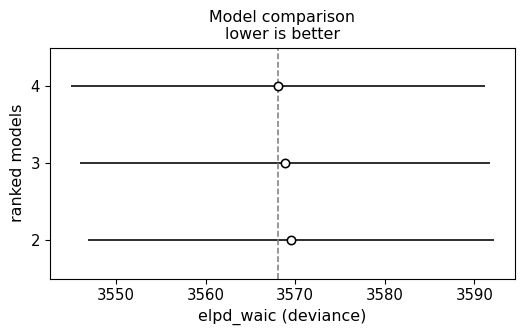

In [6]:
az.plot_compare(comp_waic)
print("WAIC comparison:")

In [7]:
comp_loo = az.compare(dict(zip([str(c) for c in clusters], idatas)),
method='BB-pseudo-BMA', ic="loo", scale="deviance")

comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
4,0,3568.115714,5.833599,0.000000,0.457149,22.485441,0.000000,False,deviance
3,1,3568.920540,5.460235,0.804826,0.271232,22.305646,0.957011,False,deviance
2,2,3569.526260,3.774296,1.410546,0.271619,22.159146,2.930551,False,deviance


LOO comparison:


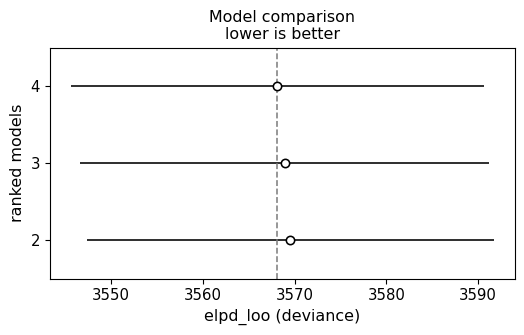

In [8]:
az.plot_compare(comp_loo)
print("LOO comparison:")

# Ex 2 
Un institut de cercetare în domeniul sănătăţii doreşte să analizeze relaţia dintre numărul de ore de exerciţii fizice pe săptămână şi nivelul de colesterol la indivizi din mai multe grupuri demografice distincte. Aceşti indivizi provin din 3 până la 5 subpopulaţii diferite (ex: vârstă, stil de viaţă, genetică), iar proporţiile fiecărei subpopulaţii în eşantion nu sunt cunoscute. Modelul presupune că fiecare individ aparţine uneia dintre subpopulaţii, fiecare având propriul său model de regresie (polinomială). Alegerea subgrupului este determinată de următoarea mixtură:

$$\text{Colesterol}_i = \sum_{i=1}^{K} w_k  \mathcal{N}( μ_{k,i}, σ_k^2)$$


unde $K$ este numărul de subpopulaţii, $w_k$ sunt ponderile subpopulaţiilor, $μ_{k,i} = α_k + β_k t_i +γ_k t_i^2$ (model polinomial), iar $σ_k$ este deviaţia standard a fiecărui model. Observaţiile privind numărul de ore de exerciţii fizice pe săptămână şi nivelul de colesterol sunt strânse în fişierul date_colesterol.csv (care are coloanele numite "Ore_exercitii", "Colesterol").

In [9]:
import pandas as pd
from pymc import math

data = pd.read_csv('date_colesterol.csv')
X = data['Ore_Exercitii'].values
Y = data['Colesterol'].values

models = []
idatas = []
K_set = [3, 4, 5]

for K in K_set:
    with pm.Model() as model:
        w = pm.Dirichlet('w', a=np.ones(K))
        alpha = pm.Normal('alpha', mu=200, sigma=30, shape=K)
        beta = pm.Normal('beta', mu=0, sigma=10, shape=K)
        gamma = pm.Normal('gamma', mu=0, sigma=2, shape=K)

        X_shared = pm.Data('X_shared', X)

        mu = pm.Deterministic("mu", math.stack([alpha[k] + beta[k] * X_shared + gamma[k] * X_shared**2 for k in range(K)], axis=1)) # [500, K]
        mu_component_means = pm.Deterministic('mu_component_means', mu.mean(axis=0)) # [3]
        sd = pm.HalfNormal('sd', sigma=10)
        y = pm.NormalMixture('y', w=w, mu=mu, sigma=sd, observed=Y)
        
        idata = pm.sample(1000, tune=2000, random_seed = 77, return_inferencedata=True)
        idatas.append(idata)
        models.append(model)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, gamma, sd]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 143 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, gamma, sd]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 237 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, gamma, sd]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 687 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


1. Estimaţi ponderile şi coeficienţii de regresie pentru fiecare subpopulaţie, pentru fiecare $K ∈ {3, 4, 5}$.

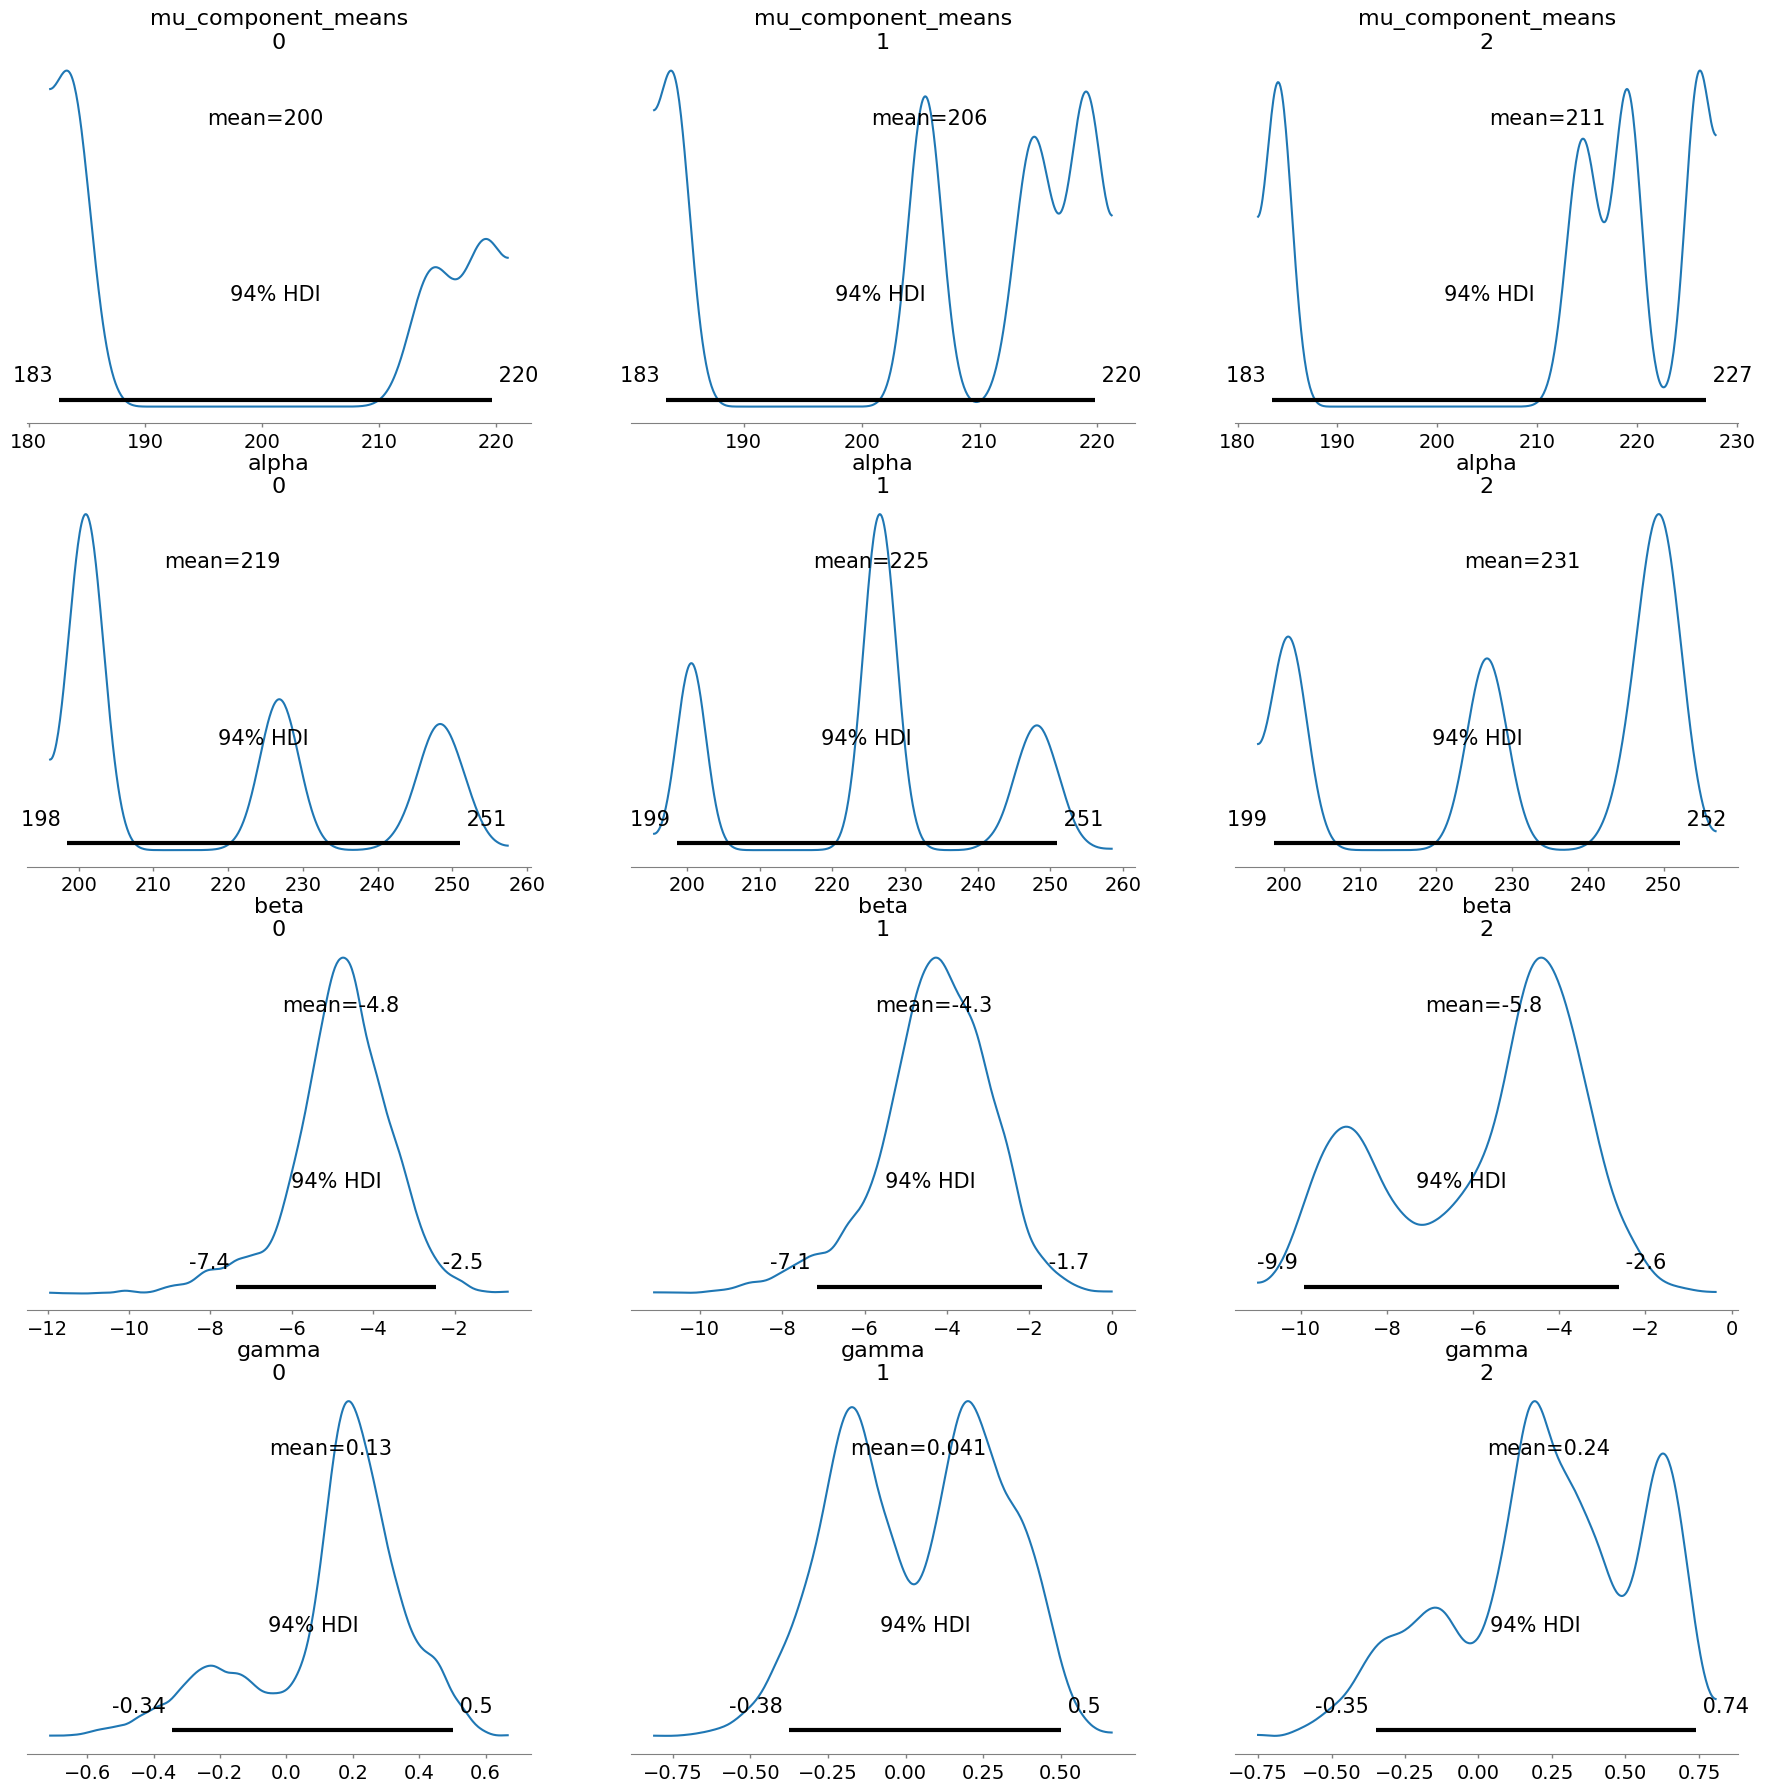

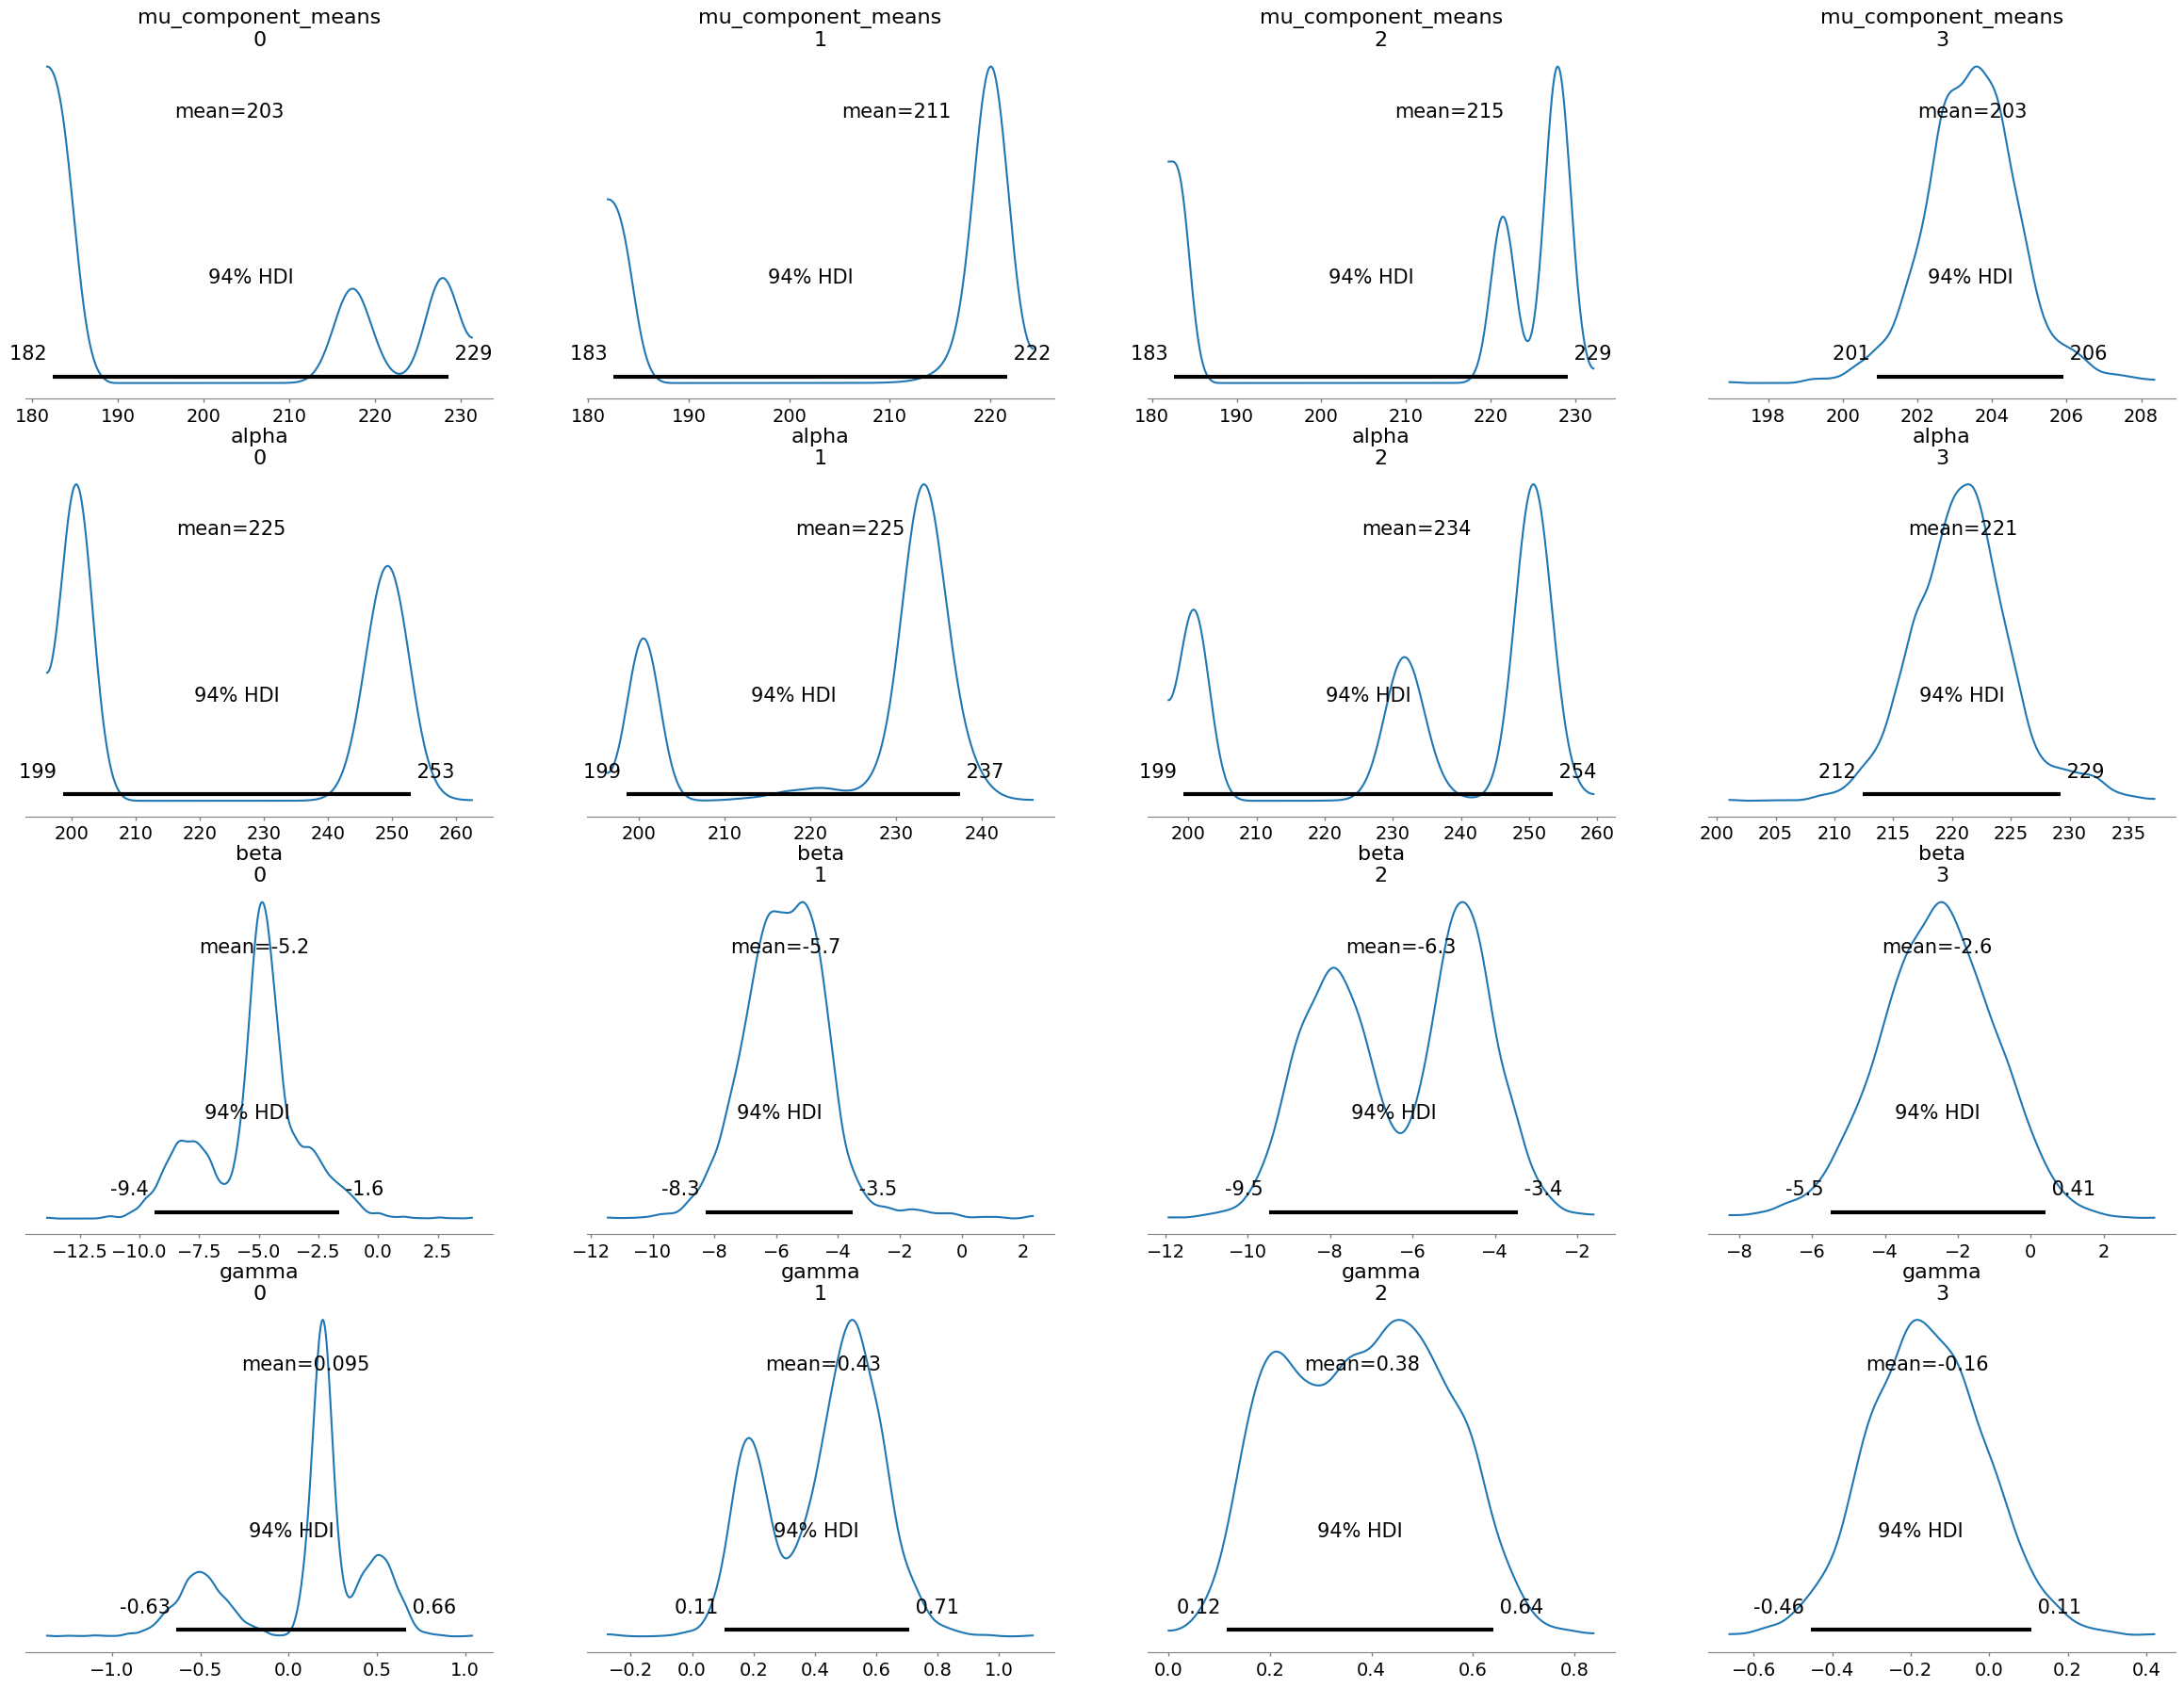

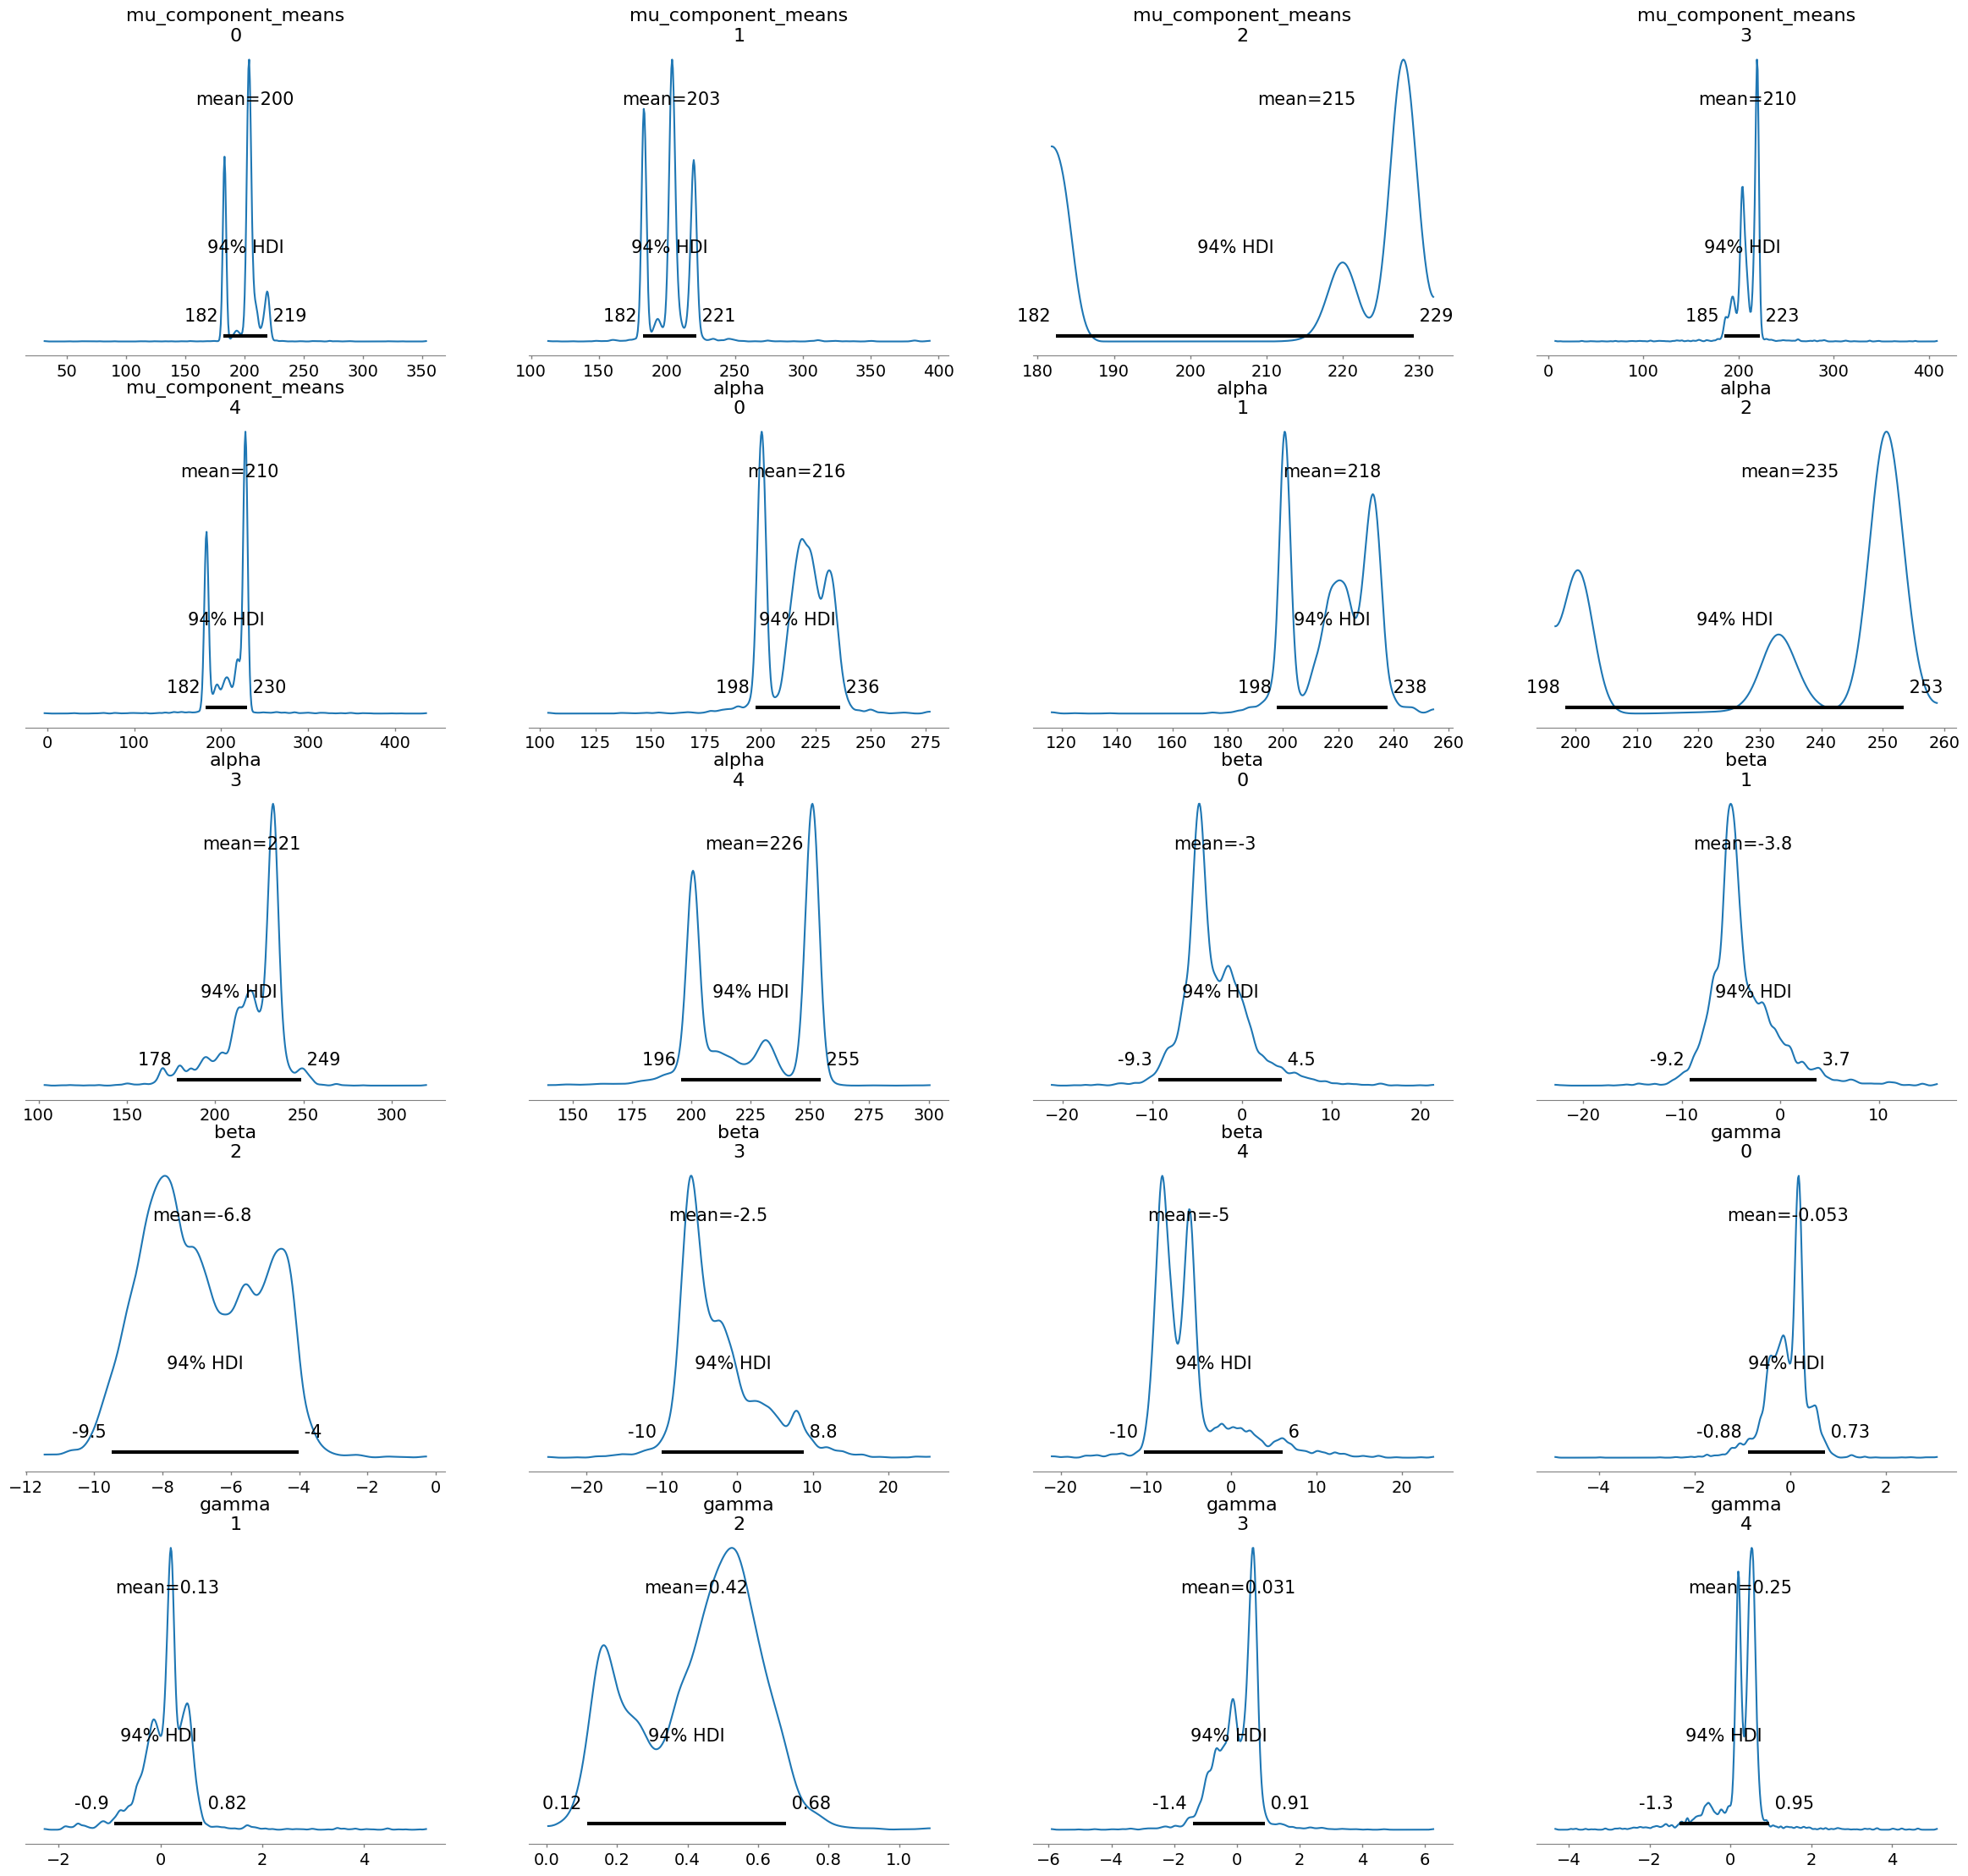

In [10]:
for i, idata in enumerate(idatas):
    az.plot_posterior(idata, var_names=['mu_component_means', 'alpha', 'beta', 'gamma'])

2. Câte subpopulaţii reprezintă cel mai bine datele observate? Justificaţi acest lucru folosind criterii
bayesiene, cum ar fi WAIC şi/sau LOO.

In [11]:
[pm.compute_log_likelihood(idatas[i], model=models[i]) for i in range(3)]

Output()

Output()

Output()

[Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data
 	> constant_data,
 Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data
 	> constant_data,
 Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data
 	> constant_data]

In [12]:
comp_waic = az.compare(dict(zip([str(K) for K in K_set], idatas)),
method='BB-pseudo-BMA', ic="waic", scale="deviance")

comp_waic

c:\Users\alex\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\alex\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\alex\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
5,0,4068.179869,19.165797,0.000000,0.875978,24.742508,0.000000,True,deviance
4,1,4072.772319,20.174378,4.592450,0.124008,25.074975,2.112689,True,deviance
3,2,4111.787818,22.563928,43.607949,0.000014,25.994753,10.667661,True,deviance


WAIC comparison:


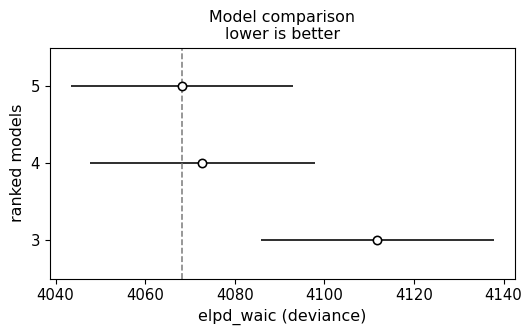

In [13]:
az.plot_compare(comp_waic)
print("WAIC comparison:")

In [14]:
comp_loo = az.compare(dict(zip([str(K) for K in K_set], idatas)),
method='BB-pseudo-BMA', ic="loo", scale="deviance")

comp_waic

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
5,0,4068.179869,19.165797,0.000000,0.875978,24.742508,0.000000,True,deviance
4,1,4072.772319,20.174378,4.592450,0.124008,25.074975,2.112689,True,deviance
3,2,4111.787818,22.563928,43.607949,0.000014,25.994753,10.667661,True,deviance


LOO comparison:


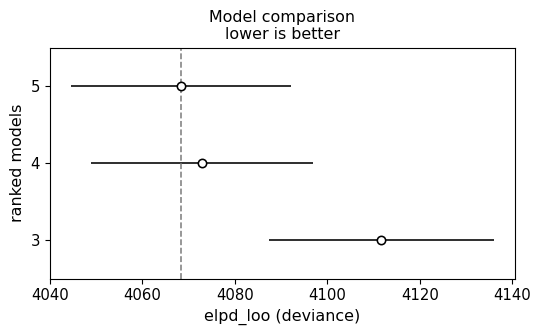

In [15]:
az.plot_compare(comp_loo)
print("LOO comparison:")